In [20]:
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import osmnx as ox
import os
import pandas as pd
import numpy as np
import importlib
from tqdm import tqdm
from datetime import datetime

import helper_functions.utils
import helper_functions.flood_utils
import helper_functions.plot_utils
import helper_functions.routing.driving
import helper_functions.routing.dryRouting
import helper_functions.routing.floodedRouting
import helper_functions.routing.publicTransit

importlib.reload(helper_functions.utils)
importlib.reload(helper_functions.flood_utils)
importlib.reload(helper_functions.plot_utils)
importlib.reload(helper_functions.routing.driving)
importlib.reload(helper_functions.routing.dryRouting)
importlib.reload(helper_functions.routing.floodedRouting)
importlib.reload(helper_functions.routing.publicTransit)

import helper_functions.utils as utils
import helper_functions.flood_utils as flood_utils
import helper_functions.plot_utils as plot_utils
import helper_functions.routing.driving as driving
import helper_functions.routing.dryRouting as dryRouting
import helper_functions.routing.floodedRouting as floodedRouting
import helper_functions.routing.publicTransit as publicTransit

# Import car and bus network

In [2]:
save_dir = os.path.join(os.getcwd(),"data")
filename = "SG_bus_network.graphml"
G_bus = ox.load_graphml(os.path.join(save_dir,filename))

### Import planning area

<class 'geopandas.geodataframe.GeoDataFrame'>


Name                                        Description  \
0  kml_1  <center><table><tr><th colspan='2' align='cent...   
1  kml_2  <center><table><tr><th colspan='2' align='cent...   
2  kml_3  <center><table><tr><th colspan='2' align='cent...   
3  kml_4  <center><table><tr><th colspan='2' align='cent...   
4  kml_5  <center><table><tr><th colspan='2' align='cent...   

                                            geometry     PLN_AREA_N  \
0  POLYGON Z ((103.93208 1.30555 0, 103.93208 1.3...          BEDOK   
1  POLYGON Z ((103.72042 1.32824 0, 103.72003 1.3...       BOON LAY   
2  POLYGON Z ((103.76408 1.37001 0, 103.76444 1.3...    BUKIT BATOK   
3  POLYGON Z ((103.82361 1.26018 0, 103.82362 1.2...    BUKIT MERAH   
4  POLYGON Z ((103.77445 1.39029 0, 103.77499 1.3...  BUKIT PANJANG   

  PLN_AREA_C CA_IND        REGION_N REGION_C           INC_CRC      FMEL_UPD_D  
0         BD      N     EAST REGION       ER  5F00E6FF084F3364  20191223152014  
1         BL      N     WEST REGION       WR  C96AED188C00B2FC  20191223152014  
2         BK      N     WEST REGION       WR  3BEC4C829160F28A  20191223152014  
3         BM      N  CENTRAL REGION       CR  4850795BB0B6A4F7  20191223152014  
4         BP      N     WEST REGION       WR  656F87D23D6DAB02  20191223152014

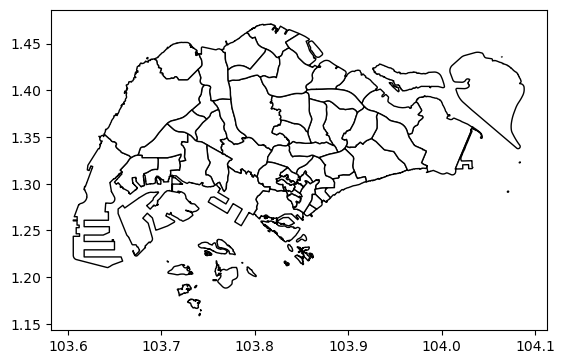

In [3]:
# planningArea_shp = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Masterplan\MasterPlan2019_PlanningArea_Fixed.shp")
# planningArea_shp.plot(fc='white',ec='k')

from bs4 import BeautifulSoup 
planningArea_noSea = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Masterplan\MasterPlan2019PlanningAreaBoundaryNoSea.geojson")

def extract_html_tags(row):
    html_content = row["Description"]
    soup = BeautifulSoup(html_content,"html.parser")
    ths = soup.find_all('th')
    tds = soup.find_all('td')
    column_names = []
    column_values = []
    for th in ths:
        column_names.append(th.get_text())
    for td in tds:
        column_values.append(td.get_text())
    column_names = column_names[1:] # remove the first "Attribute"
    return pd.Series({k:v for k,v in zip(column_names,column_values)})
# column_names, _ = extract_html_tags(planningArea_noSea.iloc[0,1])
planningArea_shp = planningArea_noSea.join(planningArea_noSea.apply(extract_html_tags,axis=1))
print(type(planningArea_shp))
planningArea_shp.plot(fc='white',ec='k')
planningArea_shp.head()

### Import work cluster

   PLN_AREA_N                  LU_DESC PLN_AREA_C     REGION_N REGION_C  \
44     TENGAH  EDUCATIONAL INSTITUTION         TH  WEST REGION       WR   

    latitude   longitude      node_ID                   geometry  
44  1.357293  103.733877  11717444138  POINT (103.73051 1.36398)  
Length of df:  50
Number of unique regions:  50


PLN_AREA_N                                    LU_DESC PLN_AREA_C  \
2          BISHAN                                 COMMERCIAL         BS   
5     BUKIT MERAH                                 COMMERCIAL         BM   
7     BUKIT TIMAH  RESIDENTIAL WITH COMMERCIAL AT 1ST STOREY         BT   
12  DOWNTOWN CORE                                    UTILITY         DT   
13        GEYLANG                                    UTILITY         GL   

          REGION_N REGION_C  latitude   longitude     node_ID  \
2   CENTRAL REGION       CR  1.353185  103.838386   310582393   
5   CENTRAL REGION       CR  1.282412  103.823409   409638755   
7   CENTRAL REGION       CR  1.333500  103.786494  6144151504   
12  CENTRAL REGION       CR  1.286690  103.852118  7202314880   
13  CENTRAL REGION       CR  1.316940  103.885235  8655329609   

                     geometry  
2   POINT (103.83839 1.35319)  
5   POINT (103.82341 1.28241)  
7    POINT (103.78649 1.3335)  
12  POINT (103.85212 1.28669)  
13  POINT (103.88524 1.31694)

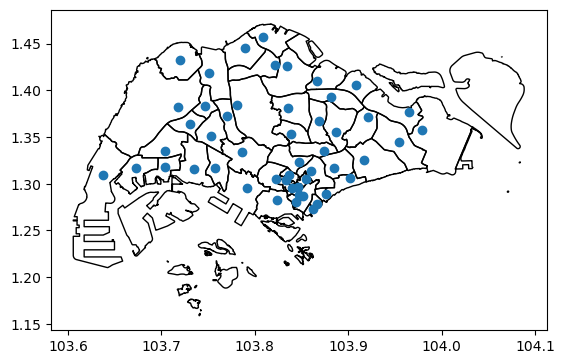

In [4]:
workplace_cluster = gpd.read_file(r"data\workplace_cluster_planningArea.shp")
# replace latitude and longitude coordinates for the row that corresponds to the PLN_AREA_N "TENGAH" because OneMap API cannot find the route for the prev coordinates
workplace_cluster.loc[workplace_cluster['PLN_AREA_N'] == 'TENGAH', ['latitude','longitude']] = [1.357293, 103.733877]
workplace_cluster.loc[workplace_cluster['PLN_AREA_N'] == 'TENGAH', 'node_ID'] = ox.distance.nearest_nodes(G_bus,X = 103.733877, Y = 1.357293)
print(workplace_cluster[workplace_cluster['PLN_AREA_N'] == 'TENGAH'])
# planningArea_shp = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Masterplan\MasterPlan2019PlanningAreaBoundaryNoSea.geojson")
workplace_cluster = workplace_cluster.sort_values(['REGION_N','PLN_AREA_N'])
print("Length of df: ",len(workplace_cluster.index))
print("Number of unique regions: ",len(workplace_cluster['PLN_AREA_C'].unique()))

ax = planningArea_shp.plot(fc="none",ec="k")
workplace_cluster.plot(ax=ax)
workplace_cluster.head()

# Bus dry isochrone

### Import public transit json routes

In [15]:
# publicTransit_dir = r"D:\PAKHUIYING\publicTransit_busRouting_busLeg_OneMap"
# publicTransit_fp_list = [os.path.join(publicTransit_dir,fp) for fp in os.listdir(publicTransit_dir) if not fp.endswith('_ERROR.json')]
# print(len(publicTransit_fp_list))
# publicTransit_fp_list[:10]
publicTransit_dir = r"data_itineraries"
# list all json files in the directory
publicTransit_fp_list = [os.path.join(publicTransit_dir,fp) for fp in os.listdir(publicTransit_dir)]
print(f"Length of fp: {len(publicTransit_fp_list)}")
publicTransit_fp_list[0]

Length of fp: 258952


'data_itineraries\\01012to11717444138.json'

In [84]:
# import one itinerary
itinerary = utils.load_json(publicTransit_fp_list[0])
itinerary

{'requestParameters': {'mode': 'TRANSIT,WALK',
  'date': '02-05-2025',
  'arriveBy': 'false',
  'showIntermediateStops': 'true',
  'fromPlace': '1.29684825487647,103.85253591654006',
  'transferPenalty': '1',
  'toPlace': '1.357293,103.733877',
  'maxWalkDistance': '1000',
  'time': '8:00 AM',
  'maxTransfers': '3',
  'numItineraries': '3'},
 'plan': {'date': 1738713600000,
  'from': {'name': 'Origin',
   'lon': 103.8525359,
   'lat': 1.2968483,
   'vertexType': 'NORMAL'},
  'to': {'name': 'Destination',
   'lon': 103.733877,
   'lat': 1.357293,
   'vertexType': 'NORMAL'},
  'itineraries': [{'duration': 3946,
    'startTime': 1738713716000,
    'endTime': 1738717662000,
    'walkTime': 1090,
    'transitTime': 2546,
    'waitingTime': 310,
    'walkDistance': 1228.54,
    'walkLimitExceeded': False,
    'generalizedCost': 12906,
    'elevationLost': 0,
    'elevationGained': 0,
    'transfers': 2,
    'fare': 'info unavailable',
    'legs': [{'startTime': 1738713716000,
      'endTime'

In [85]:
PTR = publicTransit.PublicTransitRouting.from_file(G_bus, publicTransit_fp_list[0])
short_itinerary = PTR.get_itinerary()
short_itinerary

{'start_lat': 1.29684825487647,
 'start_lon': 103.85253591654006,
 'end_lat': 1.357293,
 'end_lon': 103.733877,
 'duration': 3946,
 'startTime': 1738713716000,
 'endTime': 1738717662000,
 'transitTime': 2546,
 'waitingTime': 310,
 'transfers': 2,
 'itinerary_index': 0,
 'error_flag': False,
 'busLegs': [{'leg_number': 0,
   'duration': 670,
   'distance': 3289.53,
   'startTime': 1738716690000,
   'endTime': 1738717360000,
   'tripId': '992-1-2003',
   'tripDirection': 0,
   'mode': 'BUS',
   'routeId': '992',
   'legGeometry': {'points': '_ufGo{fxR{AxBoAw@m@r@IHwAhA????OL{@nAUh@W~@CXEx@Cx@EhEBrAB`@??`@fFJlAmC\\o@LQLc@Z]j@Or@Dv@Hj@J`AA~@Qp@????KZw@fAcCnCsB~B????yDlEkBuAgAy@c@[??oA_AqByAyBaBoDxEqCpDzAjAdB~A????B@DFpAjAdA~@xBpBzBpBbAp@fAj@tBn@zBZl@BYvFsAz@mCnC',
    'length': 68},
   'busLeg': [{'name': 'BT BATOK INT',
     'stopId': 'FERRY:43009',
     'stopCode': '43009',
     'lon': 103.7510619,
     'lat': 1.3499935,
     'arrival': 1738716526000,
     'departure': 1738716690000,
   

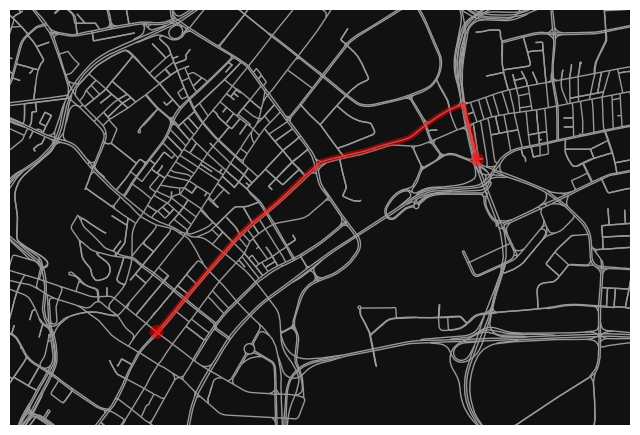

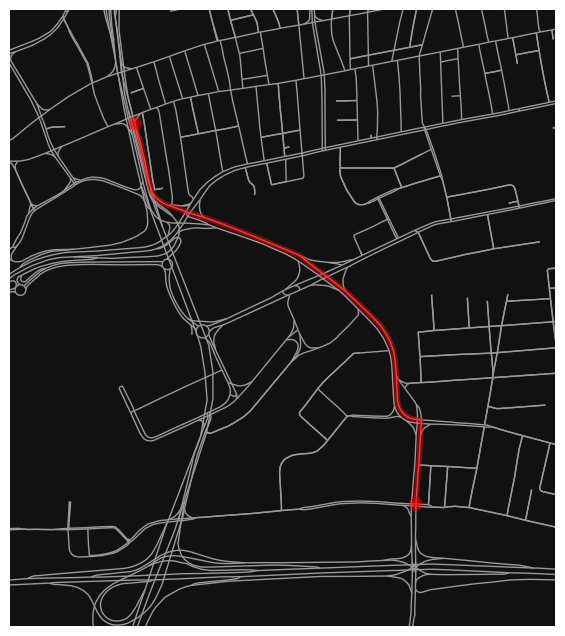

([{'leg_number': 0,
   'duration': 728,
   'distance': 3557.12,
   'startTime': 1738714247000,
   'endTime': 1738714975000,
   'tripId': '32-2-1006',
   'tripDirection': 1,
   'mode': 'BUS',
   'routeId': '32',
   'legGeometry': {'points': 'ug|F}uzxREEKIEEa@[UOoA_AIIGEA?{C}BIGIG}@o@uCaCIIGEi@a@CCAAECAC??A??AEC_CkBIGaAw@?AIG????A?CEUQoAeAs@k@MK{CiCIGMM_A_A[]c@c@UWAAY[KKCEA?????KOw@_AoA}AsA_BGIIK{@aAGIA?????CCGIoC{CwCeD?A??????OMg@k@q@o@q@o@AAs@y@YY}@}@UUKKGQO[?AOa@GMAGCSu@yEQqAIg@y@yEAA??AE???C???Co@kDCOCMSgAW[EEaBaJ{@cBMO????OSKMY]y@cAU]EIEGQYu@cAa@u@Ua@AA?AA??AA??A??AA?AAAEI??ACm@eAWk@I]a@aBMi@K]ACAEEUA??AzAQZE??^E@???@?JCvAU|@U^KBAD?bHmA',
    'length': 160},
   'busLeg': [{'name': 'HOTEL GRAND PACIFIC',
     'stopId': 'FERRY:01012',
     'stopCode': '01012',
     'lon': 103.8525359,
     'lat': 1.2968483,
     'departure': 1738714247000,
     'stopIndex': 24,
     'stopSequence': 25,
     'vertexType': 'TRANSIT',
     'arrival': nan},
    {'name': 'BUGIS STN EXIT A',
     'stopId': 

In [39]:
PTR.get_busLegs(plot=True)

{'start_lat': 1.29684825487647,
 'start_lon': 103.85253591654006,
 'end_lat': 1.288993928382467,
 'end_lon': 103.87674566755393,
 'duration': 2929,
 'transitTime': 1092,
 'waitingTime': 253,
 'transfers': 1,
 'actual_bus_duration': 1092.0,
 'simulated_bus_duration': 353,
 'actual_bus_distance': 5331.23,
 'simulated_bus_distance': 5872,
 'actual_total_duration': 2929.0,
 'simulated_total_duration': 2190.0,
 'non_bus_duration': 1837.0,
 'number_of_busroutes': 2,
 'routeId': '32,158'}

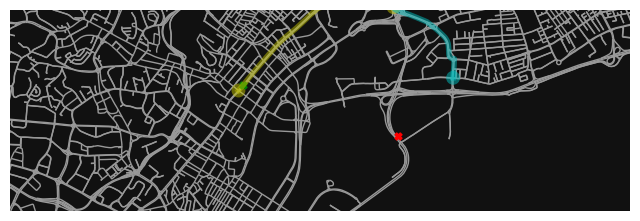

In [17]:
TI = publicTransit.TripItinerary(G_bus, short_itinerary)
TI.plot_itinerary(ylim_factor=1.5,xlim_factor=1.5)
TI.get_itinerary_entry()
# TI = publicTransit.TripItinerary.from_file(G_bus, fp=publicTransit_fp_list[1])
# itinerary_entry = TI.get_itinerary_entry()
# itinerary_entry

In [11]:
# for i, fp in tqdm(enumerate(publicTransit_fp_list)):
#     fp = os.path.basename(fp)
#     if fp == os.path.basename(r"itinerary0\22239to8133473091.json"):
#         print(i)
# save each run's errors as today's date
run_datetime = datetime.today().strftime('%Y-%m-%d %H-%M-%S')
noData_file = os.path.join(r'data',f'busRoutingError_{run_datetime}.txt')
for i, fp in tqdm(enumerate([fp for fp in publicTransit_fp_list if "to11717444138" in fp])):
# for i, fp in tqdm(enumerate(publicTransit_fp_list[49626:])):
    PTR = publicTransit.PublicTransitRouting.from_file(G_bus, fp)
    try:
        short_itinerary = PTR.get_itinerary(save_fp=os.path.join(os.getcwd(),"itinerary0",os.path.basename(fp)))
    except Exception as e:
        print(f'{i}: {fp}')
        if not os.path.exists(noData_file):
            with open(noData_file, "w") as myfile:
                myfile.write(f'{i}:{fp}:{e}\n')

        else:
            with open(noData_file, "a") as myfile:
                myfile.write(f'{i}:{fp}:{e}\n')

0it [00:00, ?it/s]

78it [01:34,  1.54s/it]

Shortest path route does not return a list: <class 'NoneType'>


1024it [1:00:06,  6.84s/it]

Shortest path route does not return a list: <class 'NoneType'>


2308it [1:49:08,  2.84s/it]


In [16]:
itinerary0 = os.path.join(os.getcwd(),"itinerary0")
itinerary0 = [os.path.join(itinerary0,fp) for fp in os.listdir(itinerary0)]
print(f"Length of publicTransit_fp_list: {len(publicTransit_fp_list)}")
print(f"length of itinerary0: {len(itinerary0)}")
itinerary0[0]

Length of publicTransit_fp_list: 258952
length of itinerary0: 258952


'c:\\Users\\hypak\\OneDrive - Singapore Management University\\Documents\\Projects\\Risk Assessment\\V3 analysis\\itinerary0\\01012to11717444138.json'

In [ ]:
# def test_func(bool_val):
#     if bool_val:
#         return {'1':1,'2':2}
    
# x = [True,False,True]
# def test_func1(x):
#     for i in x:
#         y = test_func(i)
#         if y is not None:
#             yield y
# pd.DataFrame.from_records(test_func1(x))
# a generator function that yields an itinerary entry

# noData_file = os.path.join(r'data','error_itineraryEntry_log1.txt')
# for fp in itinerary0:
#     try:
#         publicTransit.TripItinerary.from_file(G_bus, fp=fp).get_itinerary_entry()
#     except Exception as e:
#         if not os.path.exists(noData_file):
#             with open(noData_file, "w") as myfile:
#                 myfile.write(f'{fp}:{e}\n')

#         else:
#             with open(noData_file, "a") as myfile:
#                 myfile.write(f'{fp}:{e}\n')

# concatenate the generator into a single DataFrame
itinerary_df = pd.DataFrame.from_records(publicTransit.itinerary_entry_generator(G_bus,itinerary0))
# remove rows with number_of_busroutes == 0
itinerary_df = itinerary_df[itinerary_df['number_of_busroutes'] > 0]
# append nodes ID to the start and end coordinates
itinerary_df['start_nodesID'] = ox.distance.nearest_nodes(G_bus,X = itinerary_df['start_lon'], Y = itinerary_df['start_lat'])
itinerary_df['end_nodesID'] = ox.distance.nearest_nodes(G_bus,X = itinerary_df['end_lon'], Y = itinerary_df['end_lat'])
# itinerary_df.to_csv(os.path.join(r"data","bus_routing_OneMap_planningArea.csv"),index=False)
itinerary_df.head()

start_lat   start_lon   end_lat     end_lon  duration  transitTime  \
0   1.296848  103.852536  1.357293  103.733877      3946         2546   
1   1.296848  103.852536  1.288994  103.876746      2929         1092   
2   1.296848  103.852536  1.316833  103.757449      2754         2144   
3   1.296848  103.852536  1.296378  103.846693       747           43   
4   1.296848  103.852536  1.355380  103.887346      2463         1226   

   waitingTime  transfers  actual_bus_duration  simulated_bus_duration  \
0          310          2                670.0                     253   
1          253          1               1092.0                     353   
2          417          2                626.0                     257   
3            0          0                 43.0                      27   
4          160          1                701.0                     203   

   actual_bus_distance  simulated_bus_distance  actual_total_duration  \
0              3289.53                    3633                 3946.0   
1              5331.23                    5872                 2929.0   
2              3344.23                    3912                 2754.0   
3               316.61                     461                  747.0   
4              3281.77                    3388                 2463.0   

   simulated_total_duration  non_bus_duration  number_of_busroutes routeId  \
0                    3529.0            3276.0                    1     992   
1                    2190.0            1837.0                    2  32,158   
2                    2385.0            2128.0                    2   2,201   
3                     731.0             704.0                    1       2   
4                    1965.0            1762.0                    1     133   

   start_nodesID  end_nodesID  
0     4748705954  11717444138  
1     4748705954   1315917427  
2     4748705954   1357034975  
3     4748705954   1363263601  
4     4748705954   1366728322

### spatial join public transit csv with planning area
- Will use `CarTrip.spatial_join_with_planning_area()` even though public transit is not the same as car trip, but we will just use `CarTrip`'s method to do the spatial join

In [ ]:
itinerary_master_df = pd.read_csv(os.path.join(r"data","bus_routing_OneMap_planningArea - Copy.csv"))
print("length of df: ",len(itinerary_df.index))
print("Number of unique end_nodesID: ",len(set(itinerary_master_df['end_nodesID'])))

CT = driving.CarTrip(G_bus, workplace_cluster,planningArea=planningArea_shp)
itinerary_master_df = CT.spatial_join_with_planning_area(itinerary_master_df,prefix="start")
itinerary_master_df = CT.spatial_join_with_planning_area(itinerary_master_df,prefix="end")
# itinerary_master_df.to_csv(os.path.join(r"data","bus_routing_OneMap_planningArea.csv"),index=False)
itinerary_master_df.head()

length of df:  1186200
Number of unique end_nodesID:  50


start_lat   start_lon   end_lat     end_lon  duration  transitTime  \
0   1.296848  103.852536  1.357293  103.733877      3946         2546   
1   1.296848  103.852536  1.288994  103.876746      2929         1092   
2   1.296848  103.852536  1.316833  103.757449      2754         2144   
3   1.296848  103.852536  1.296378  103.846693       747           43   
4   1.296848  103.852536  1.355380  103.887346      2463         1226   

   waitingTime  transfers  actual_bus_duration  simulated_bus_duration  ...  \
0          310          2                670.0                     253  ...   
1          253          1               1092.0                     353  ...   
2          417          2                626.0                     257  ...   
3            0          0                 43.0                      27  ...   
4          160          1                701.0                     203  ...   

   start_nodesID  end_nodesID  start_PLN_AREA_N  start_PLN_AREA_C  \
0     4748705954  11717444138            ROCHOR                RC   
1     4748705954   1315917427            ROCHOR                RC   
2     4748705954   1357034975            ROCHOR                RC   
3     4748705954   1363263601            ROCHOR                RC   
4     4748705954   1366728322            ROCHOR                RC   

   start_REGION_N  start_REGION_C end_PLN_AREA_N  end_PLN_AREA_C  \
0  CENTRAL REGION              CR         TENGAH              TH   
1  CENTRAL REGION              CR    MARINA EAST              ME   
2  CENTRAL REGION              CR       CLEMENTI              CL   
3  CENTRAL REGION              CR         MUSEUM              MU   
4  CENTRAL REGION              CR        HOUGANG              HG   

        end_REGION_N end_REGION_C  
0        WEST REGION           WR  
1     CENTRAL REGION           CR  
2        WEST REGION           WR  
3     CENTRAL REGION           CR  
4  NORTH-EAST REGION          NER  

[5 rows x 27 columns]

### Read public transit csv and split itinerary based on unique end nodes e.g. end_nodesID

In [10]:
# itinerary_master_df = pd.read_csv(os.path.join(r"data","bus_routing_OneMap.csv"))
# read file
itinerary_master_df = pd.read_csv(os.path.join(r"data","bus_routing_OneMap_planningArea.csv"))
print("length of df: ",len(itinerary_master_df.index))
print("Number of unique end_nodesID: ",len(set(itinerary_master_df['end_nodesID'])))
print(itinerary_master_df.dtypes)
# merge itinerary_master_df with workplace cluster based on end_nodesID
# itinerary_master_df = pd.merge(itinerary_master_df,workplace_cluster[['node_ID','PLN_AREA_N','REGION_N']],left_on='end_nodesID',right_on='node_ID',how='left')
# group by end_nodesID
itinerary_df_list = {k:df for k,df in itinerary_master_df.groupby('end_nodesID')}
print("Number of dataframes after groupby: ",len(list(itinerary_df_list)))
# check if there are workplace nodes not in itinerary df
missing_workplace_nodes = list(set(list(itinerary_df_list))^set(workplace_cluster['node_ID']))
if len(missing_workplace_nodes) > 0:
    # identify the workplace nodes that are not in itinerary df
    print(workplace_cluster[workplace_cluster['node_ID'].isin(missing_workplace_nodes)])
    print("Workplace nodes that are not in itinerary df: ",missing_workplace_nodes)
# workplace_cluster.dtypes

length of df:  374581
Number of unique end_nodesID:  50
start_lat                   float64
start_lon                   float64
end_lat                     float64
end_lon                     float64
duration                      int64
transitTime                   int64
waitingTime                   int64
transfers                     int64
actual_bus_duration         float64
simulated_bus_duration        int64
actual_bus_distance         float64
simulated_bus_distance        int64
actual_total_duration       float64
simulated_total_duration    float64
non_bus_duration            float64
number_of_busroutes           int64
routeId                      object
start_nodesID                 int64
end_nodesID                   int64
start_PLN_AREA_N             object
start_PLN_AREA_C             object
start_REGION_N               object
start_REGION_C               object
end_PLN_AREA_N               object
end_PLN_AREA_C               object
end_REGION_N                 object
end_REGI

### Print meta data

In [95]:
# pd.DataFrame.from_records({k: len(v.index) for k,v in itinerary_df_list.items()})
itinerary_metadata = pd.DataFrame.from_records({'end_nodesID':list(itinerary_df_list),'length_entries':[len(i.index) for i in itinerary_df_list.values()]})
# merge itinerary metadata with workplace cluster by their node_ID
itinerary_metadata = pd.merge(itinerary_metadata,workplace_cluster[['node_ID','PLN_AREA_N','REGION_N','latitude','longitude']],left_on='end_nodesID',right_on='node_ID',how='left')
# itinerary_metadata.to_csv(os.path.join(r"data","bus_routing_OneMap_planningArea_metadata.csv"),index=False)
itinerary_metadata.head()

end_nodesID  length_entries    node_ID               PLN_AREA_N  \
0     74389915            8001   74389915             RIVER VALLEY   
1    158014842            6733  158014842  CENTRAL WATER CATCHMENT   
2    231901188            7172  231901188               ANG MO KIO   
3    236310575            8092  236310575                  KALLANG   
4    237218543            7811  237218543          SINGAPORE RIVER   

            REGION_N  latitude   longitude  
0     CENTRAL REGION  1.295921  103.839648  
1       NORTH REGION  1.384552  103.780568  
2  NORTH-EAST REGION  1.380772  103.835564  
3     CENTRAL REGION  1.313737  103.860608  
4     CENTRAL REGION  1.287837  103.847174

### Plot dry public transit isochrone
- Only itineraries with at least 1 bus route is plotted
- Each subplot represents itinerary to a unique work cluster

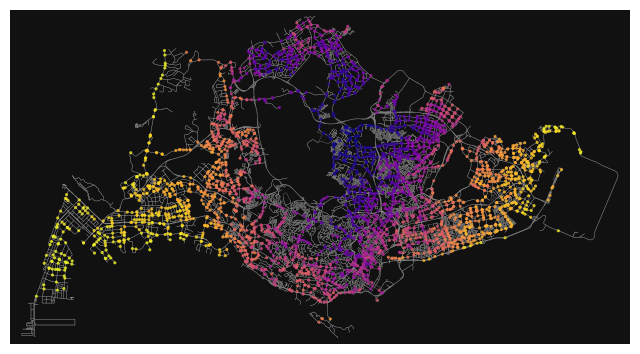

In [11]:
# import dry weather public transit routing
# itinerary_master_df = pd.read_csv(os.path.join(r"data","bus_routing_OneMap.csv"))
ISO = dryRouting.PlotIsochrone(G_bus,itinerary_master_df,planningArea_shp)
# group itinerary_df by planning area to return a dictionary of dataframes, where the key is the planning area name, and the value is the dataframe
itinerary_df_list = ISO.get_grouped_itinerary_df(groupby_name="end_PLN_AREA_N")
bus_route_times = ISO.plot_shortest_path_route(itinerary_df_list[list(itinerary_df_list)[0]],column_value="actual_total_duration")

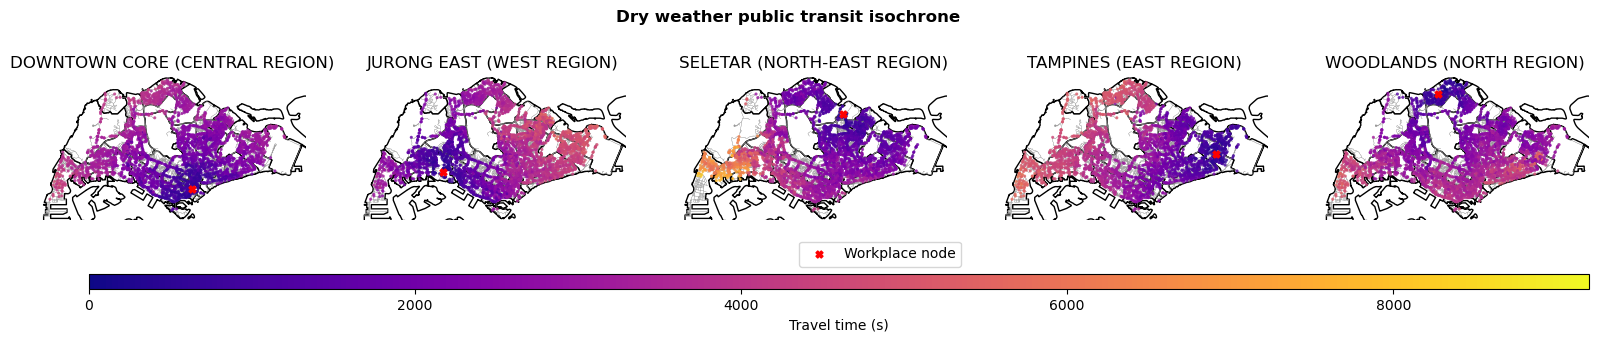

In [12]:
# # import dry weather public transit routing
# itinerary_master_df = pd.read_csv(os.path.join(r"data","bus_routing_OneMap.csv"))
# save_fp = os.path.join(r"data\floodRouting","dry_isochrone_publicTransit_workClusters.png")
# ISO = dryRouting.PlotIsochrone(G_bus,itinerary_master_df,planningArea_shp)
# ISO.plot_isochrone(flooded_edges=None,column_value="actual_total_duration",
#                    colorbar_label="Travel time (s)", 
#                    title="Dry weather public transit isochrone",
#                    save_fp=save_fp)

# filter representative planning area isochrones for each administrative region
selected_planningArea = ['TAMPINES','JURONG EAST','WOODLANDS','DOWNTOWN CORE','SELETAR']
selected_itinerary = {k:df for k,df in itinerary_df_list.items() 
                      if k in selected_planningArea}
# name of saved figure
save_fp = os.path.join(r"data\floodRouting","dry_isochrone_publicTransit_workClusters1.png")
# plot isochrone
ISO.plot_isochrone(selected_itinerary, flooded_edges=None,
                   column_value="simulated_total_duration",
                   colorbar_label="Travel time (s)", ncols = len(list(selected_itinerary)),
                   title="Dry weather public transit isochrone",
                   cbar_orientation="horizontal",
                   save_fp=save_fp)

TODO: 

#### Raster analysis
- Map raster inundation map over edges in `G_car` and `G_bus`, pixel by pixel (coord by coord), and add the pixel value (i.e. flood depth) as an attribute `flood_depth` to the edges
    - obtain the geographical coordinates of each pixel's centroid (it may be possible that 1 pixel cover multiple roads, so use pixel centroid instead) and their flood depth
    - obtain closest edge (road) based on coords
- Update edges' attributes - `max_speed` and `travel_time` 

#### Vector/point analysis
If there is no raster inundation map, we will just look at the roads that were flooded at these scenarios - 90th, 95th, 99th, and 99.9th percentile for the max 30 mins rainfall
- Use the `precipitation_levels_during_flood_events.csv` to identify all the roads that have been flooded (in recent times e.g. >=2020) for each rainfall type percentile
- identify relevant road edges for each scenario
- Update edges' attributes - `max_speed` and `travel_time` 

**Rerun flood risk analysis for 2014 to 2024**

1. Can we find out which bus sevices are most likely to be impacted?
2. Can we identify the critical road segments that result in the highest time delay?

# Vector impact travel time analysis

### Import historical flood events

In [7]:
historical_floods = pd.read_csv(r"Flood_Weather_Data\precipitation_levels_during_flood_events.csv")
print(historical_floods.dtypes)
print("Length of df: ",len(historical_floods.index))
print("Number of unique flood events: ",len(historical_floods['matched_location'].unique()))
historical_floods.head()

flooded_location                  object
responses_found                    int64
matched_location                  object
latitude                         float64
longitude                        float64
closest_weather_stn               object
mean_pr                          float64
daily rainfall total (mm)        float64
highest 30 min rainfall (mm)     float64
highest 60 min rainfall (mm)     float64
highest 120 min rainfall (mm)    float64
drainage_catchment                object
time                              object
dtype: object
Length of df:  220
Number of unique flood events:  144


flooded_location  responses_found                      matched_location  \
0           Yishun MRT                9            ATM DBS YISHUN MRT STATION   
1  2 KAKI BUKIT ROAD 3                1  2 KAKI BUKIT ROAD 3 SINGAPORE 417817   
2         PSC Building                1                          PSC BUILDING   
3     21229 (bus stop)                1                      21229 (BUS STOP)   
4       Tengah Flyover                1                        TENGAH FLYOVER   

   latitude   longitude closest_weather_stn    mean_pr  \
0  1.429525  103.834995              Yishun  17.395082   
1  1.337334  103.901943            Tai Seng   7.993548   
2  1.328863  103.706189     Boon Lay (West)  14.574603   
3  1.342064  103.716020      Jurong (North)  14.574603   
4  1.363822  103.707043      Jurong (North)  22.195238   

   daily rainfall total (mm)  highest 30 min rainfall (mm)  \
0                       45.0                          40.8   
1                       25.0                          21.0   
2                       89.5                          49.5   
3                       65.4                          51.6   
4                       92.6                          50.2   

   highest 60 min rainfall (mm)  highest 120 min rainfall (mm)  \
0                          44.0                           44.2   
1                          25.0                           25.0   
2                          83.0                           89.0   
3                          63.8                           65.4   
4                          78.4                           92.2   

  drainage_catchment        time  
0          Woodlands  2014-03-20  
1            Geylang  2014-04-04  
2             Jurong  2014-04-23  
3             Jurong  2014-04-23  
4             Kranji  2014-05-16

### Import historical weather data

In [8]:
imported_data_dir = os.path.join(os.getcwd(),"Flood_Weather_Data")
percentiles, historical_ppt_percentiles = flood_utils.get_historical_ppt_percentiles(fp=os.path.join(imported_data_dir,"historical_weather.csv"),
                                                                         percentiles=[90,95,99,99.9])
print(percentiles)
print(historical_ppt_percentiles)

[90, 95, 99, 99.9]
{'highest 30 min rainfall (mm)': array([13.8, 21.2, 35.6, 51.4]), 'highest 60 min rainfall (mm)': array([17.    , 26.8   , 47.2   , 70.4767]), 'highest 120 min rainfall (mm)': array([19. , 30.2, 55. , 85. ])}


### Identify flooded roads by rain percentile

TODO:
- convert rainfall percentile values to 1 in ? return period of rainfall. We do not have a 1 in ? year of flood event as pluvial flood drain out pretty fast. PUB does have a drainage code of practice that can handle a 1 in 100 year flood.
- for each derived flooded roads for **rainfall value** and **rainfall type**, update the speed and travel time.
- **Determining travel speed during flooding**: sort travel speed bands in `TravelSpeedBands.*.csv` to obtain the lowest speed band during a rainfall event. Select a representative road and obtain the respective speed band e.g. Ang mo kio ave 4 has speed band 2, which corresponds to *10-19km/h*
- identify critical road segments that needs prioritisation of flood risk reduction (i.e. identify the road segment that creates the highest time delay when flooded)
- identify which roads have the highest likelihood of flood?

- Scenarios analysis:
    - speed changes based on flood depth e.g. [Pregnolato et al (2017)](https://www.sciencedirect.com/science/article/pii/S1361920916308367) proposed a depth-disruption function to estimate a relationship between road inundation depth and traffic disruption based on existing empirical studies. *Note*: Only achievable if we have the flood inundation raster map
    - flood depth > 15 - 40 cm, cars stall, road takes 30 - 60 minutes to drain out water. Minimum delay is the delay that it takes for the water to drain away from the road i.e. at most 1 hour.
    - Train routing, which train stations are the most critical which creates the highest time delay when flooded?

# Compute global flooded roads
1. Compute global flooded roads by considering that multiple roads flood simultaneously

TODO:

2. Compute flooded roads individually to do a sensitivity analysis

3. Find the road that has the highest betweeness and centrality score

4. Simulate road closures on critical roads `G.remove_edge(u,v)`

### Get flooded edges

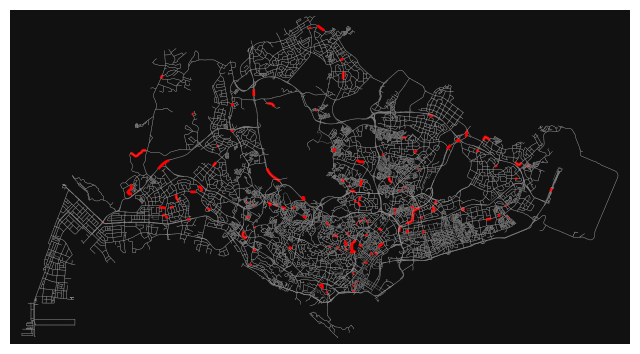

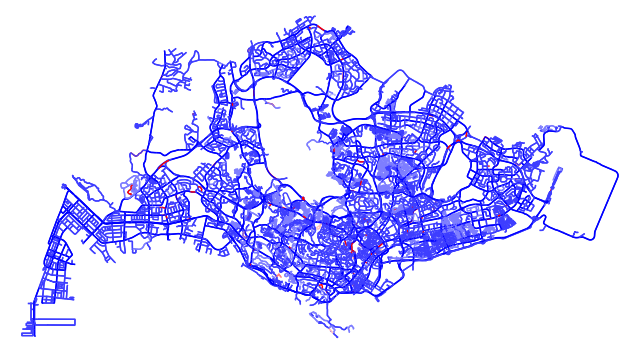

In [13]:
UFN = floodedRouting.UpdateFloodNetwork(G_bus, flooded_maxspeed=5)
# show flooded edges
flooded_edges = UFN.identify_flooded_roads(historical_floods,51,rf_type='highest 30 min rainfall (mm)',plot=True,
                                           flooded_edge_color="red",edge_color="#999999")
# show updated network road speed
UFN.update_flooded_road_network(flooded_edges, cmap="bwr_r",node_size=0,bgcolor="white")

In [21]:
itinerary0 = os.path.join(os.getcwd(),"itinerary0")
itinerary0 = [os.path.join(itinerary0,fp) for fp in os.listdir(itinerary0)]
print(f"length of itinerary0: {len(itinerary0)}")
itinerary0[0]

length of itinerary0: 258952


'c:\\Users\\hypak\\OneDrive - Singapore Management University\\Documents\\Projects\\Risk Assessment\\V3 analysis\\itinerary0\\01012to11717444138.json'

In [22]:
# parameter inputs
save_dir = r"data\floodRouting"
rf_type = 'highest 60 min rainfall (mm)'
rf_perc = 99.9
rf_map = {perc:rf_val for perc, rf_val in zip(percentiles,list(historical_ppt_percentiles[rf_type]))}
rf_value = rf_map[rf_perc]
flooded_maxspeed = 5 # km/h
# get flooded edges
UFN = floodedRouting.UpdateFloodNetwork(G_bus, flooded_maxspeed=flooded_maxspeed)
# show flooded edges
flooded_edges = UFN.identify_flooded_roads(historical_floods,rf_value,rf_type=rf_type,plot=False,
                                        flooded_edge_color="red",edge_color="#999999")

# save fp
save_fp = os.path.join(save_dir,f"bus_routing_rfType{rf_type}_rfPerc{rf_perc}_maxspeed{flooded_maxspeed}1.csv")

# update car network with flooded edges and rerun routing simulation
UFN = floodedRouting.UpdateFloodNetwork(G_bus, flooded_maxspeed=flooded_maxspeed)
# itinerary df is derived from identifying flooded roads from historically flooded roads, and update travel speed and time in G
# # save error data here
# noData_file = os.path.join(r'data','error_itineraryEntry_log3.txt')
# itinerary_df = UFN.get_flooded_publicTransit_df(publicTransit_fp_list,flooded_edges,
#                                     save_fp=save_fp, error_fp=noData_file)
itinerary_df = UFN.get_flooded_publicTransit_df(itinerary0,flooded_edges,
                                    save_fp=save_fp, error_fp=None)

# import data and read data
bus_flooded_df = pd.read_csv(save_fp)
bus_dry_df = pd.read_csv(os.path.join(r"data","bus_routing_OneMap_planningArea.csv"))

# title from plot
title = f"{rf_value:.2f} ({rf_perc}th of {rf_type})\nMax speed on flooded roads = {flooded_maxspeed} km/h"

# compute travel time delay
save_fp = os.path.join(save_dir,f"bus_barPlot_timeDelay_rfType{rf_type}_rfPerc{rf_perc}_maxspeed{flooded_maxspeed}.png")
TTD = floodedRouting.TravelTimeDelay(bus_flooded_df,bus_dry_df,planningArea_shp,
                                    column_value="simulated_total_duration")

# compute travel time delay by comparing the difference in dry_df and flooded_df
travel_time_delay_df = TTD.compute_travel_time_delay()
travel_time_delay_df.head()

KeyboardInterrupt: 

In [ ]:
print("Length of df: ",len(travel_time_delay_df))
print("Number of unique end_nodesID: ",len(set(travel_time_delay_df.reset_index()['end_nodesID'])))
print("Number of unique planning area: ",len(set(travel_time_delay_df['PLN_AREA_N'])))
print("Number of unique regions: ",len(set(travel_time_delay_df['REGION_N'])))
# group travel time delay by planning area and region and calculate sum and mean of travel time delay


Length of df:  1162477
Number of unique end_nodesID:  50
Number of unique planning area:  50
Number of unique regions:  5


PLN_AREA_N               REGION_N         
ANG MO KIO               NORTH-EAST REGION    23724
BEDOK                    EAST REGION          23724
BISHAN                   CENTRAL REGION       23724
BOON LAY                 WEST REGION          23724
BUKIT BATOK              WEST REGION          23724
BUKIT MERAH              CENTRAL REGION       23724
BUKIT PANJANG            WEST REGION          23724
BUKIT TIMAH              CENTRAL REGION       23724
CENTRAL WATER CATCHMENT  NORTH REGION         23724
CHANGI                   EAST REGION          23724
CHOA CHU KANG            WEST REGION          23724
CLEMENTI                 WEST REGION          23724
DOWNTOWN CORE            CENTRAL REGION       23724
GEYLANG                  CENTRAL REGION       23724
HOUGANG                  NORTH-EAST REGION    23724
JURONG EAST              WEST REGION          23724
JURONG WEST              WEST REGION          23724
KALLANG                  CENTRAL REGION       23724
LIM CHU KANG         

In [45]:
# aggregate travel time delay by plannning area and region and calculate count, sum, mean as separate columns
def summarise_func(row):
    # initialise dictionary
    d = row['travel_time_delay'].describe().to_dict()
    IQR = d['75%'] - d['25%']
    d['whislow'] = d['25%'] - 1.5*IQR
    d['whishigh'] = d['75%'] + 1.5*IQR
    d['sum'] = row['travel_time_delay'].sum()
    return pd.Series(d,index=list(d))
    
# travel_time_delay_df.groupby(['PLN_AREA_N','REGION_N'])['travel_time_delay'].agg(['count','sum','mean']).reset_index()
travel_time_delay_df.groupby(['PLN_AREA_N','REGION_N']).apply(lambda x: summarise_func(x)).reset_index()

C:\Users\hypak\AppData\Local\Temp\ipykernel_61796\527583339.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  travel_time_delay_df.groupby(['PLN_AREA_N','REGION_N']).apply(lambda x: summarise_func(x)).reset_index()


PLN_AREA_N           REGION_N    count        mean  \
0                ANG MO KIO  NORTH-EAST REGION  23724.0   16.927120   
1                     BEDOK        EAST REGION  23724.0    3.938817   
2                    BISHAN     CENTRAL REGION  23724.0    4.583300   
3                  BOON LAY        WEST REGION  23724.0    9.283752   
4               BUKIT BATOK        WEST REGION  23724.0   19.056730   
5               BUKIT MERAH     CENTRAL REGION  23724.0    7.891461   
6             BUKIT PANJANG        WEST REGION  23724.0   70.604036   
7               BUKIT TIMAH     CENTRAL REGION  23724.0   26.606189   
8   CENTRAL WATER CATCHMENT       NORTH REGION  23724.0   86.467972   
9                    CHANGI        EAST REGION  23724.0    7.367227   
10            CHOA CHU KANG        WEST REGION  23724.0   64.244945   
11                 CLEMENTI        WEST REGION  23724.0   12.671135   
12            DOWNTOWN CORE     CENTRAL REGION  23724.0    6.196063   
13                  GEYLANG     CENTRAL REGION  23724.0    5.277391   
14                  HOUGANG  NORTH-EAST REGION  23724.0    3.139343   
15              JURONG EAST        WEST REGION  23724.0   11.312638   
16              JURONG WEST        WEST REGION  23724.0   80.576303   
17                  KALLANG     CENTRAL REGION  23724.0    3.476467   
18             LIM CHU KANG       NORTH REGION  23724.0   17.972434   
19                   MANDAI       NORTH REGION  23724.0   19.990709   
20              MARINA EAST     CENTRAL REGION  23724.0    6.508160   
21             MARINA SOUTH     CENTRAL REGION  23724.0    6.794353   
22            MARINE PARADE     CENTRAL REGION  23724.0    4.686461   
23                   MUSEUM     CENTRAL REGION  23724.0    4.871488   
24                   NEWTON     CENTRAL REGION  23724.0   14.374001   
25                   NOVENA     CENTRAL REGION  23724.0    3.922991   
26                  ORCHARD     CENTRAL REGION  23724.0    7.693206   
27                   OUTRAM     CENTRAL REGION  23724.0   15.624886   
28                PASIR RIS        EAST REGION  23724.0    6.084684   
29               PAYA LEBAR        EAST REGION  23724.0    4.616506   
30                  PIONEER        WEST REGION  23724.0   10.834415   
31                  PUNGGOL  NORTH-EAST REGION  23724.0   17.148042   
32               QUEENSTOWN     CENTRAL REGION  23724.0   10.267287   
33             RIVER VALLEY     CENTRAL REGION  23724.0    6.018010   
34                   ROCHOR     CENTRAL REGION  23724.0    7.867137   
35                  SELETAR  NORTH-EAST REGION  23724.0   17.203247   
36                SEMBAWANG       NORTH REGION  23724.0   24.349408   
37                 SENGKANG  NORTH-EAST REGION  23724.0   13.413498   
38                SERANGOON  NORTH-EAST REGION  23724.0    2.774566   
39          SINGAPORE RIVER     CENTRAL REGION  23724.0    7.455126   
40             STRAITS VIEW     CENTRAL REGION  23724.0    6.793381   
41             SUNGEI KADUT       NORTH REGION  23724.0  102.075930   
42                 TAMPINES        EAST REGION  23724.0    3.202308   
43                  TANGLIN     CENTRAL REGION  23724.0    9.060499   
44                   TENGAH        WEST REGION  23724.0   22.239777   
45                TOA PAYOH     CENTRAL REGION  23724.0    2.674094   
46                     TUAS        WEST REGION  23724.0   12.539739   
47  WESTERN WATER CATCHMENT        WEST REGION  23724.0   78.275555   
48                WOODLANDS       NORTH REGION  23724.0   27.269640   
49                   YISHUN       NORTH REGION  23724.0   17.973235   

          std  min        25%        50%         75%          max     whislow  \
0   39.589304  0.0   0.000000   0.000000   23.216448  1016.257024  -34.824673   
1   21.843016  0.0   0.000000   0.000000    0.000000  1016.257024    0.000000   
2   19.486864  0.0   0.000000   0.000000    0.000000  1016.257024    0.000000   
3   26.211491  0.0   0.000000   0.000000    0.000000  1016.257024    0.

In [12]:

# plot horizontal bar chart
TTD.plot_total_travel_time_delay(title=title,save_fp=None)

# plot isochrone
save_fp = os.path.join(save_dir,f"car_isochrone_timeDelay_rfType{rf_type}_rfPerc{rf_perc}_maxspeed{flooded_maxspeed}.png")
ISO = dryRouting.PlotIsochrone(G_car,travel_time_delay_df,planningArea_shp)
ISO.plot_isochrone(flooded_edges=flooded_edges,column_value="travel_time_delay",
                cmap="spring_r",flooded_edge_color="blue",
                colorbar_label="Total travel time delay (s)", title=title,
                save_fp=None)

KeyError: 'REGION_N'

# Bus wet weather isochrone

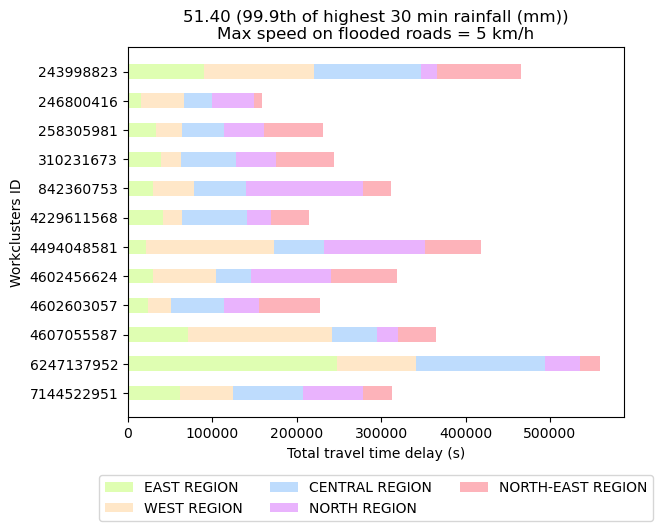

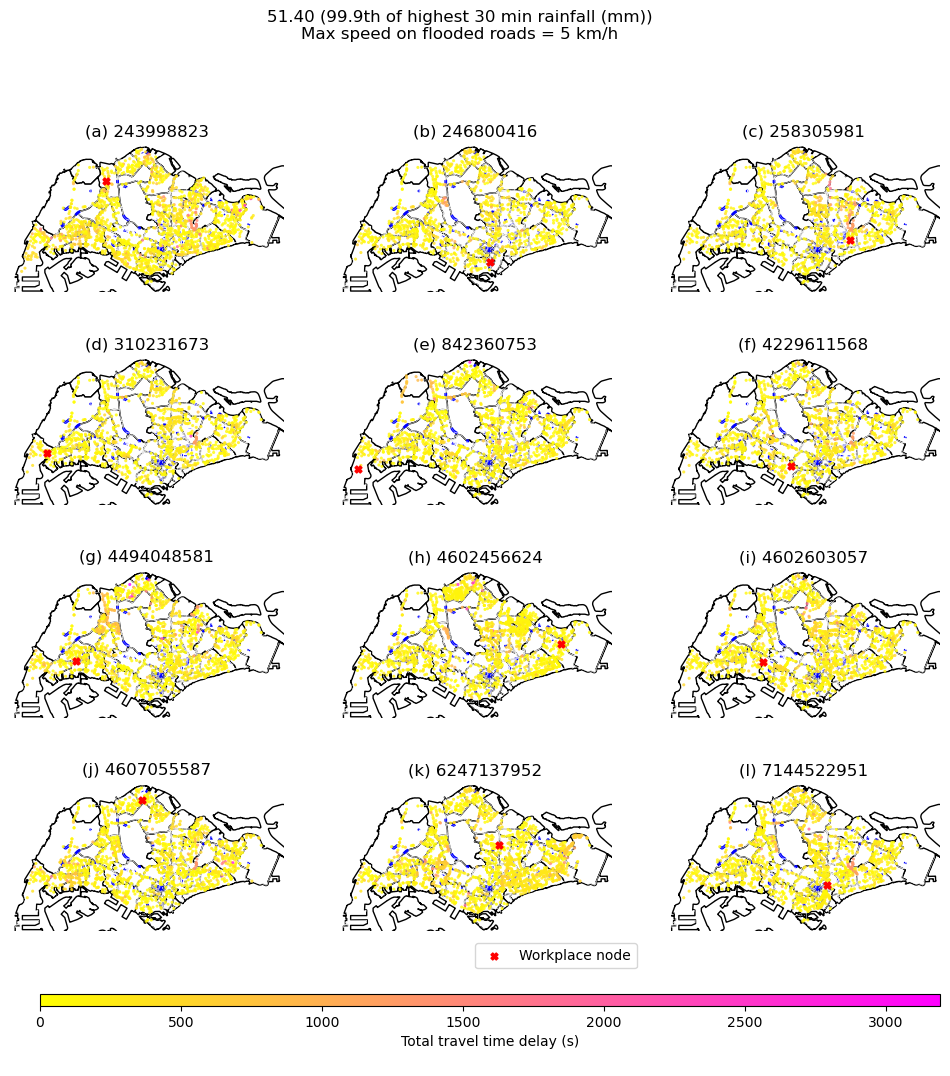

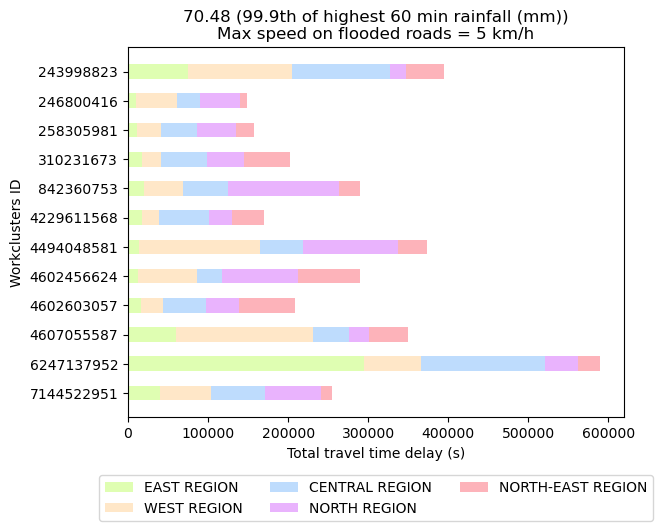

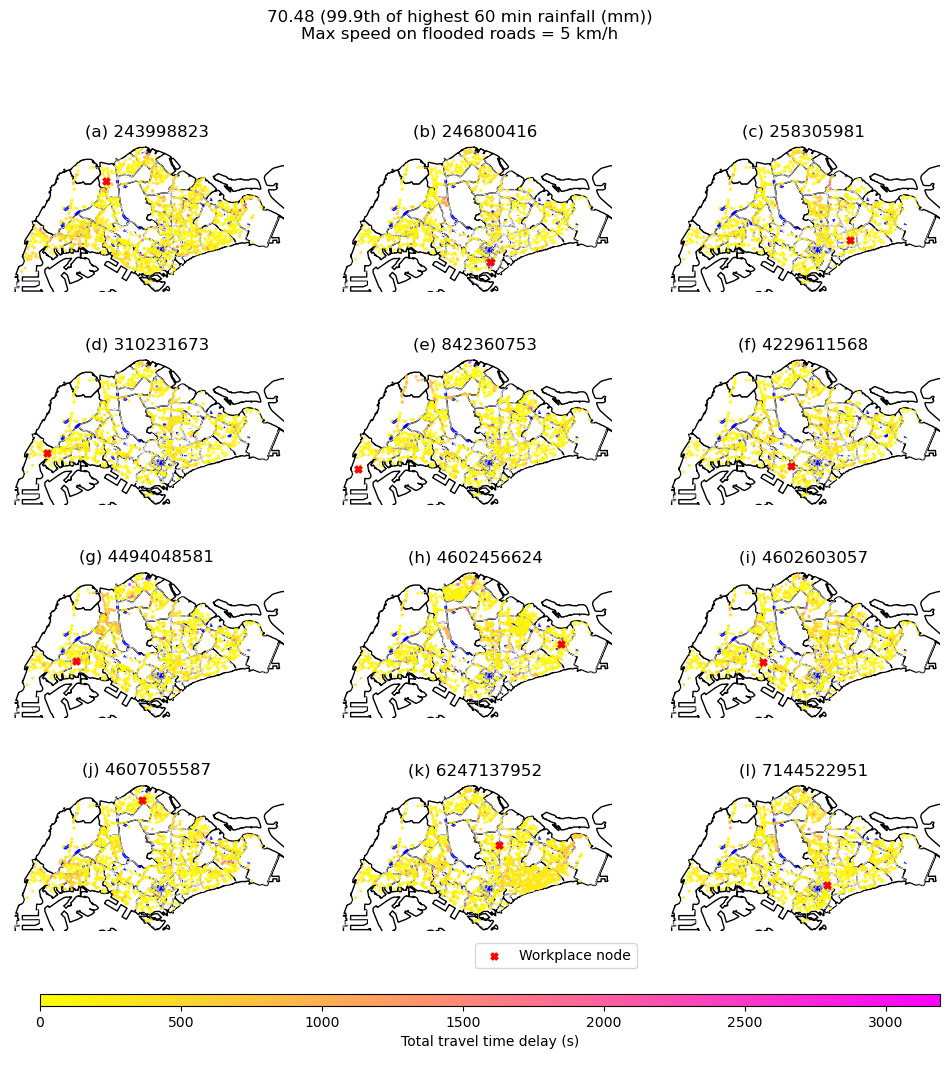

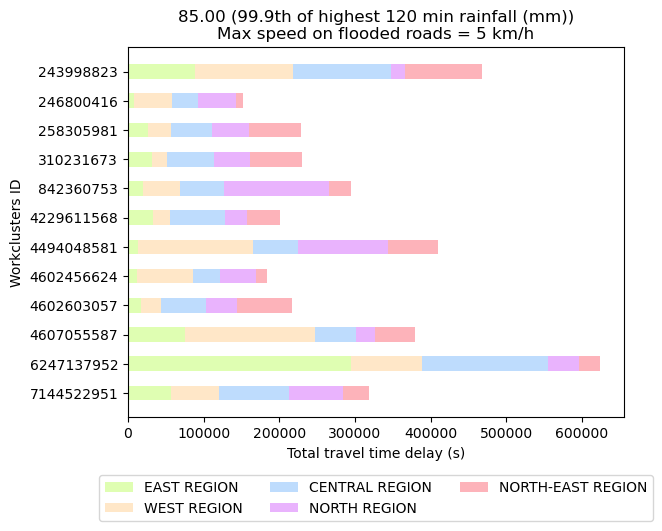

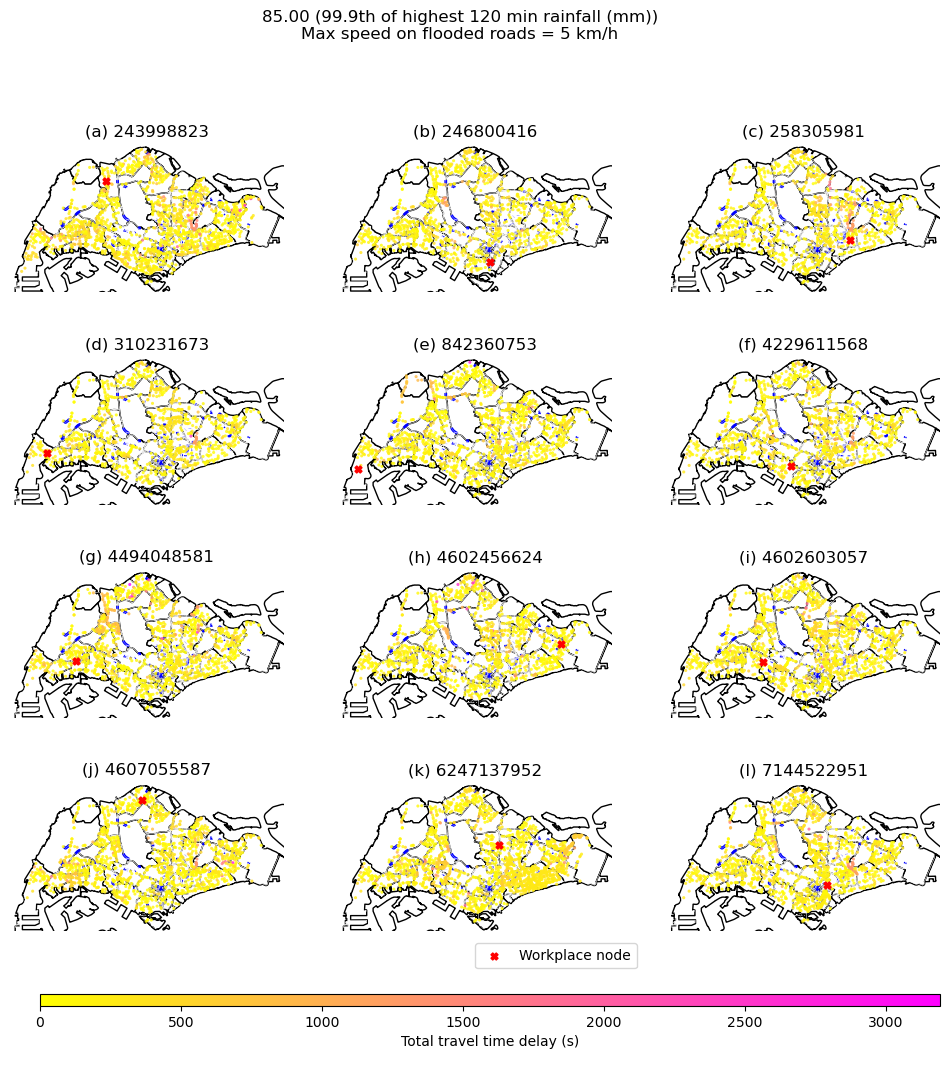

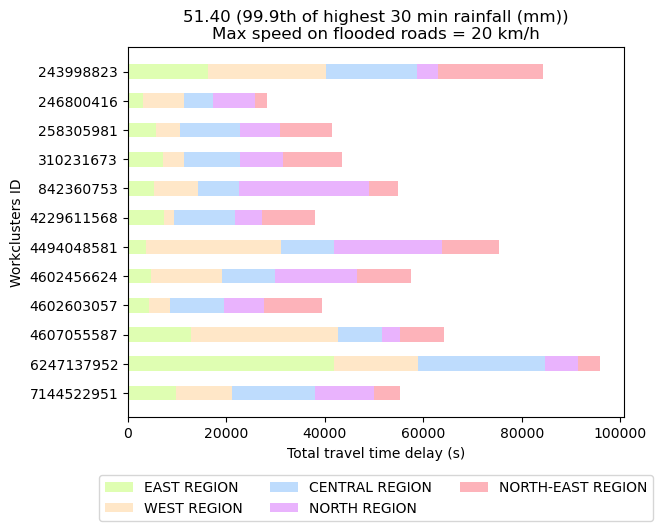

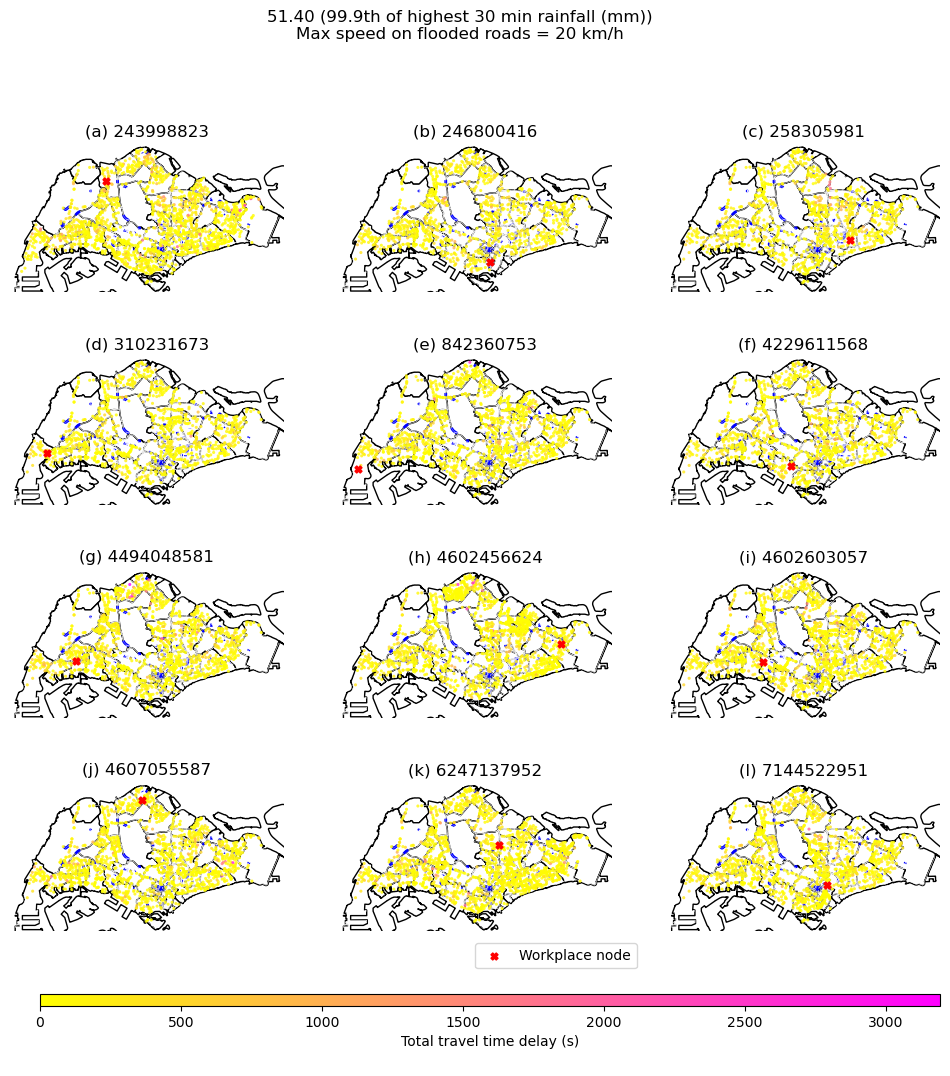

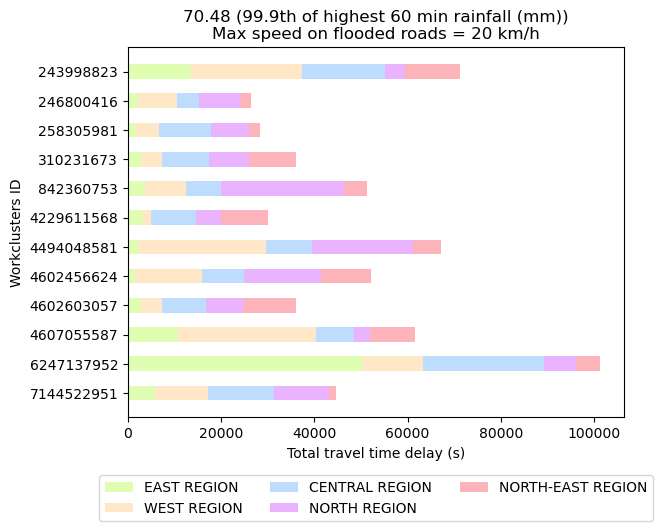

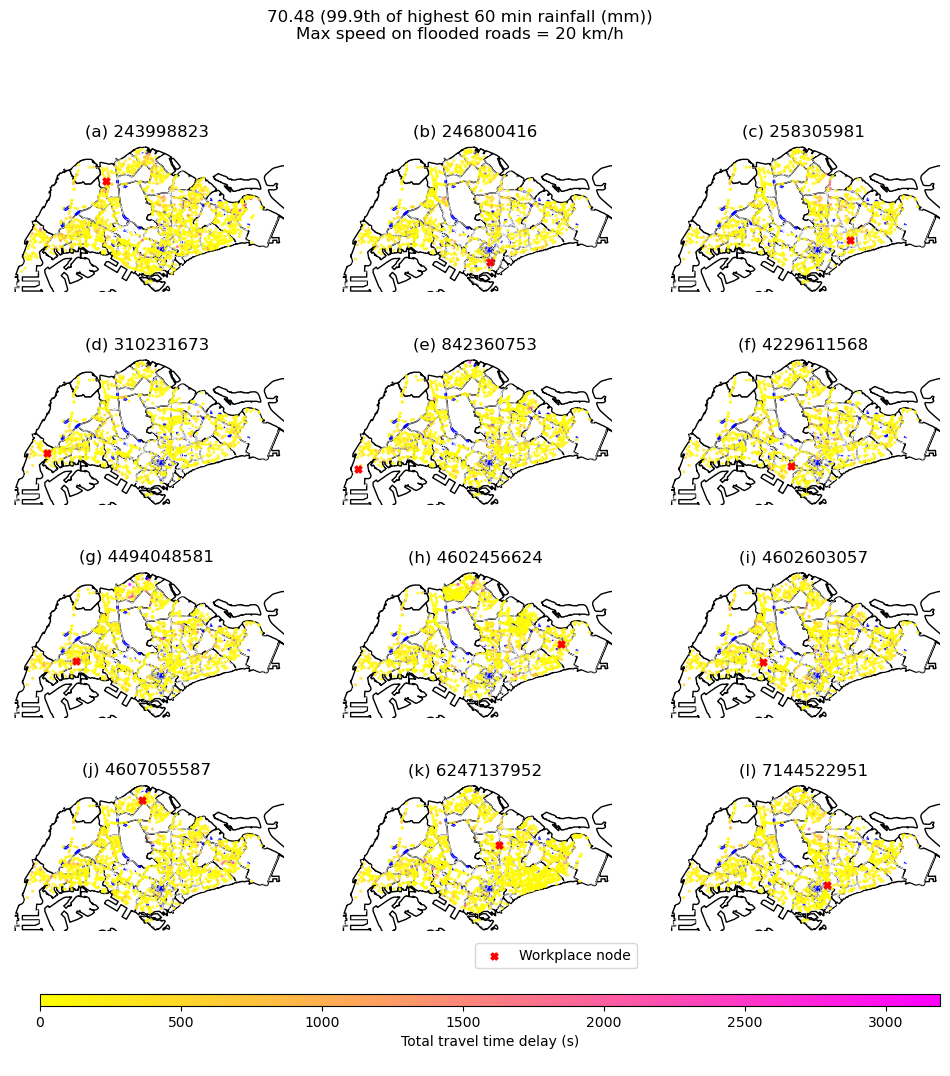

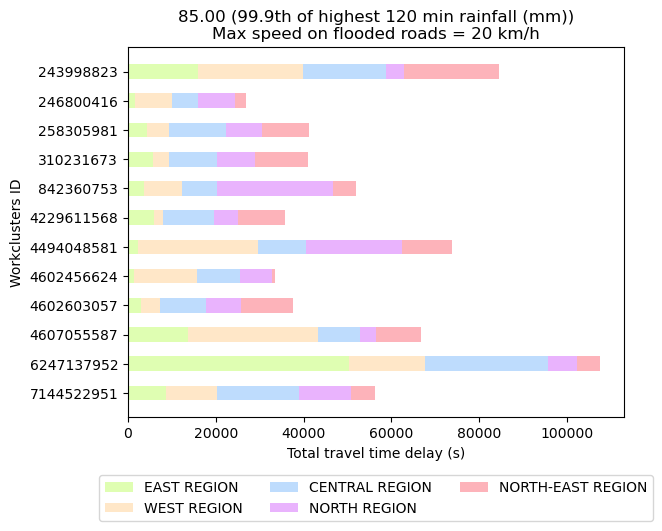

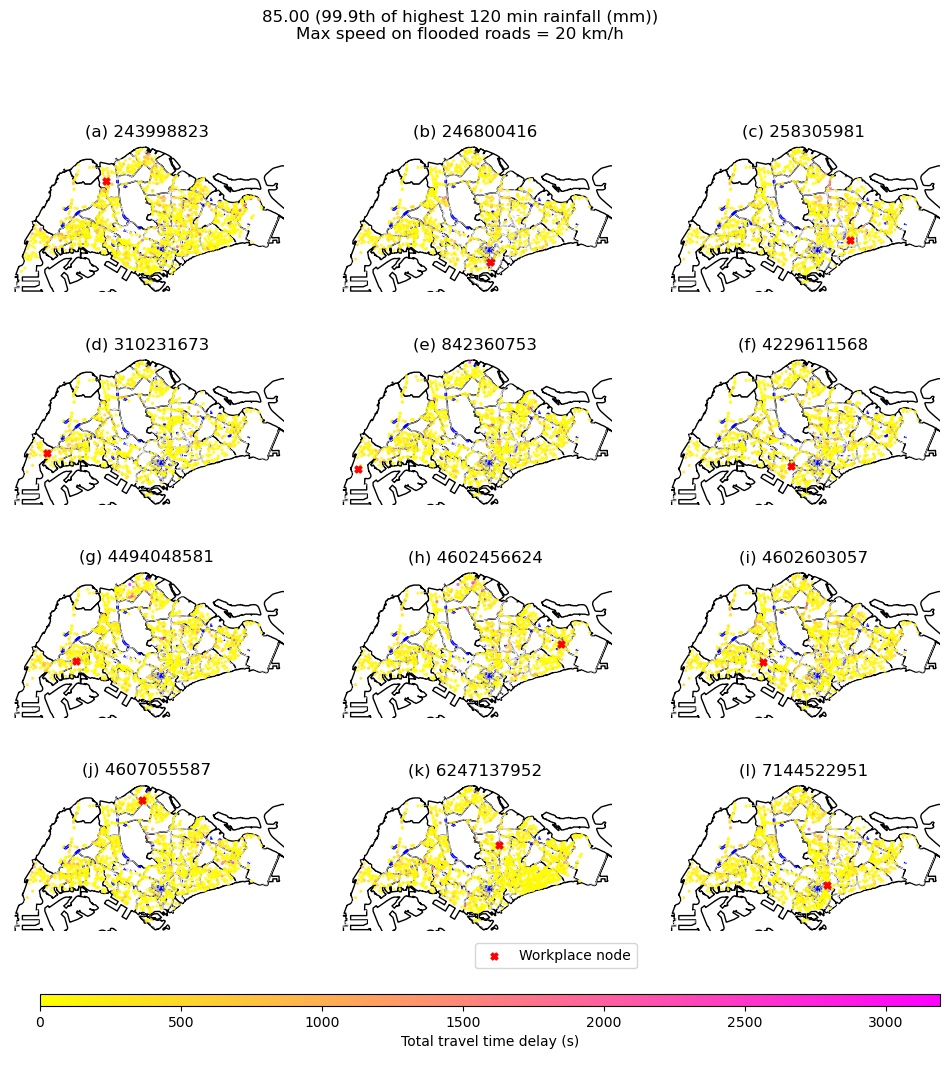

In [312]:
# parameter inputs
save_dir = r"data\floodRouting"

for flooded_maxspeed in [5,20]:
    for rf_type in ['highest 30 min rainfall (mm)','highest 60 min rainfall (mm)','highest 120 min rainfall (mm)']:
        # flooded_maxspeed = int(5)
        # rf_type = 'highest 60 min rainfall (mm)'
        rf_perc = 99.9
        rf_map = {perc:rf_val for perc, rf_val in zip(percentiles,list(historical_ppt_percentiles[rf_type]))}
        rf_value = rf_map[rf_perc]
        
        # get flooded edges
        UFN = floodedRouting.UpdateFloodNetwork(G_bus, flooded_maxspeed=flooded_maxspeed)
        # show flooded edges
        flooded_edges = UFN.identify_flooded_roads(historical_floods,rf_value,rf_type=rf_type,plot=False,
                                                flooded_edge_color="red",edge_color="#999999")


        # save fp
        save_fp = os.path.join(save_dir,f"bus_routing_rfType{rf_type}_rfPerc{rf_perc}_maxspeed{flooded_maxspeed}.csv")

        # update car network with flooded edges and rerun routing simulation
        UFN = floodedRouting.UpdateFloodNetwork(G_bus, flooded_maxspeed=flooded_maxspeed)
        # itinerary df is derived from identifying flooded roads from historically flooded roads, and update travel speed and time in G
        # save error data here
        noData_file = os.path.join(r'data','error_itineraryEntry_log3.txt')
        itinerary_df = UFN.get_flooded_publicTransit_df(publicTransit_fp_list,flooded_edges,
                                            save_fp=save_fp, error_fp=noData_file)

        # import data and read data
        bus_flooded_df = pd.read_csv(save_fp)
        bus_dry_df = pd.read_csv(os.path.join(os.getcwd(),"data","bus_routing_OneMap.csv"))

        # title from plot
        title = f"{rf_value:.2f} ({rf_perc}th of {rf_type})\nMax speed on flooded roads = {flooded_maxspeed} km/h"

        # compute travel time delay
        save_fp = os.path.join(save_dir,f"bus_barPlot_timeDelay_rfType{rf_type}_rfPerc{rf_perc}_maxspeed{flooded_maxspeed}.png")
        TTD = floodedRouting.TravelTimeDelay(bus_flooded_df,bus_dry_df,planningArea_shp,
                                            column_value="simulated_total_duration")

        # compute travel time delay by comparing the difference in dry_df and flooded_df
        travel_time_delay_df = TTD.compute_travel_time_delay()

        # plot horizontal bar chart
        TTD.plot_total_travel_time_delay(title=title,save_fp=save_fp)

        # plot isochrone
        save_fp = os.path.join(save_dir,f"bus_isochrone_timeDelay_rfType{rf_type}_rfPerc{rf_perc}_maxspeed{flooded_maxspeed}.png")
        ISO = dryRouting.PlotIsochrone(G_bus,travel_time_delay_df,planningArea_shp)
        ISO.plot_isochrone(flooded_edges=flooded_edges,column_value="travel_time_delay",
                        cmap="spring_r",flooded_edge_color="blue",
                        colorbar_label="Total travel time delay (s)", title=title,
                        save_fp=save_fp)

# Get summary stats

In [ ]:
# parameter inputs
save_dir = r"data\floodRouting"

for travel_mode in ['car', 'bus']:
    for flooded_maxspeed in [5,20]:
        for rf_type in ['highest 30 min rainfall (mm)','highest 60 min rainfall (mm)','highest 120 min rainfall (mm)']:
            rf_perc = 99.9
            rf_map = {perc:rf_val for perc, rf_val in zip(percentiles,list(historical_ppt_percentiles[rf_type]))}
            rf_value = rf_map[rf_perc]

            # save fp
            save_fp = os.path.join(save_dir,f"{travel_mode}_routing_rfType{rf_type}_rfPerc{rf_perc}_maxspeed{flooded_maxspeed}.csv")

            # import data and read wet weather data
            flooded_df = pd.read_csv(save_fp)
            # import data and read dry weather data
            if travel_mode == 'bus':
                dry_df = pd.read_csv(os.path.join(os.getcwd(),"data","bus_routing_OneMap.csv"))
                G = G_bus
            else:
                dry_df = pd.read_csv(os.path.join(os.getcwd(),"data","car_routing_osmnx.csv"))
                G = G_car

            
            TTD = floodedRouting.TravelTimeDelay(flooded_df,dry_df,planningArea_shp,
                                                 column_value="simulated_total_duration",
                                                 planningArea_column_value="REGION_N")
            # compute travel time delay by comparing the difference in dry_df and flooded_df
            travel_time_delay_df = TTD.compute_travel_time_delay()

            # title from plot
            title = f"{rf_value:.2f} ({rf_perc}th of {rf_type})\nMax speed on flooded roads = {flooded_maxspeed} km/h"
            
            # plot horizontal bar chart
            save_fp = os.path.join(save_dir,f"{travel_mode}_barPlot_timeDelay_rfType{rf_type}_rfPerc{rf_perc}_maxspeed{flooded_maxspeed}.png")
            TTD.plot_total_travel_time_delay(title=title,save_fp=save_fp)

            # plot isochrone
            save_fp = os.path.join(save_dir,f"{travel_mode}_isochrone_timeDelay_rfType{rf_type}_rfPerc{rf_perc}_maxspeed{flooded_maxspeed}.png")
            ISO = dryRouting.PlotIsochrone(G,travel_time_delay_df,planningArea_shp)
            ISO.plot_isochrone(flooded_edges=flooded_edges,column_value="travel_time_delay",
                            cmap="spring_r",flooded_edge_color="blue",
                            colorbar_label="Total travel time delay (s)", title=title,
                            save_fp=save_fp)
            
            # compute stats aggregated by region REGION_N
            save_fp = os.path.join(save_dir,f"{travel_mode}_stats_timeDelay_rfType{rf_type}_rfPerc{rf_perc}_maxspeed{flooded_maxspeed}.csv")
            TTD.get_stats_travel_time_delay(save_fp=save_fp)
            

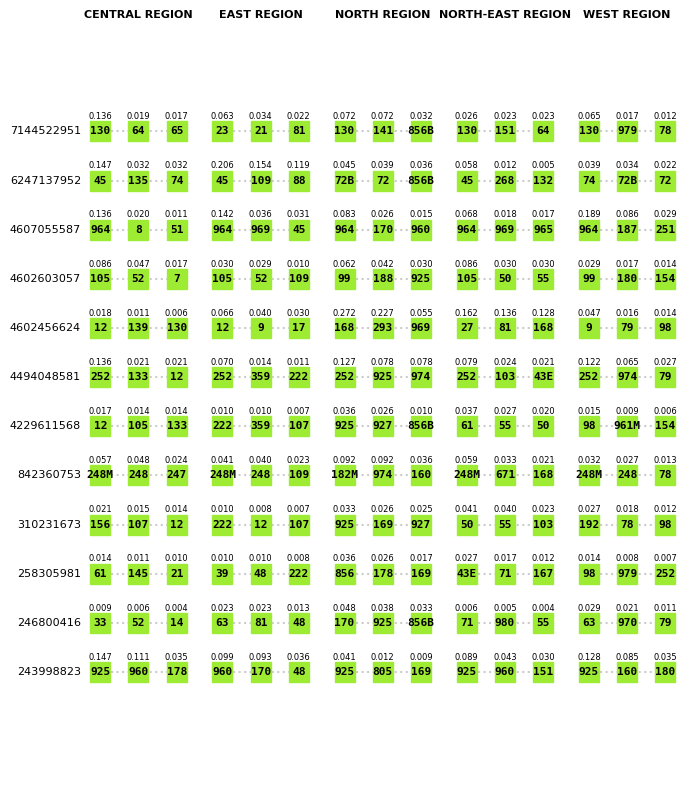

In [572]:
flooded_df = pd.read_csv(r"data\floodRouting\bus_routing_rfTypehighest 30 min rainfall (mm)_rfPerc99.9_maxspeed5.csv")
dry_df = pd.read_csv(r"data\bus_routing_OneMap.csv")
TTD = floodedRouting.TravelTimeDelay(flooded_df,dry_df,planningArea_shp,
                                    column_value="simulated_total_duration",
                                    planningArea_column_value="REGION_N")
# stats_travel_time_delay = TTD.get_stats_travel_time_delay()
# compute stats aggregated by region REGION_N
TTD.plot_bus_services_disruption(save_fp=r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Projects\Risk Assessment\V3 analysis\data\floodRouting\busServicesDisrupted_rfTypehighest 30 min rainfall (mm)_rfPerc99.9_maxspeed5.png")

In [574]:
flooded_df = pd.read_csv(r"data\floodRouting\bus_routing_rfTypehighest 30 min rainfall (mm)_rfPerc99.9_maxspeed20.csv")
dry_df = pd.read_csv(r"data\bus_routing_OneMap.csv")

# flooded_df = pd.read_csv(r"data\floodRouting\car_routing_rfTypehighest 30 min rainfall (mm)_rfPerc99.9_maxspeed5.csv")
# dry_df = pd.read_csv(r"data\car_routing_osmnx.csv")

len(flooded_df.index)

62764

c:\Users\hypak\OneDrive - Singapore Management University\Documents\Projects\Risk Assessment\V3 analysis\helper_functions\routing\floodedRouting.py:210: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  route_times = {k: v for k, v in sorted(route_times.items(), key=lambda item: item[1])}


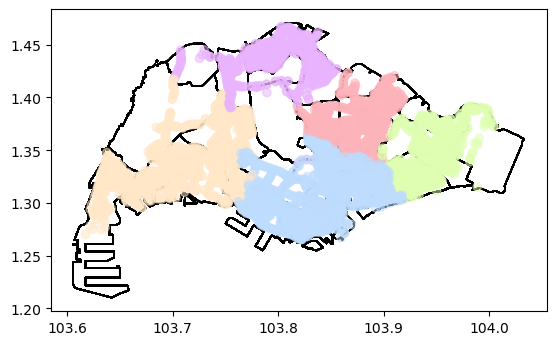

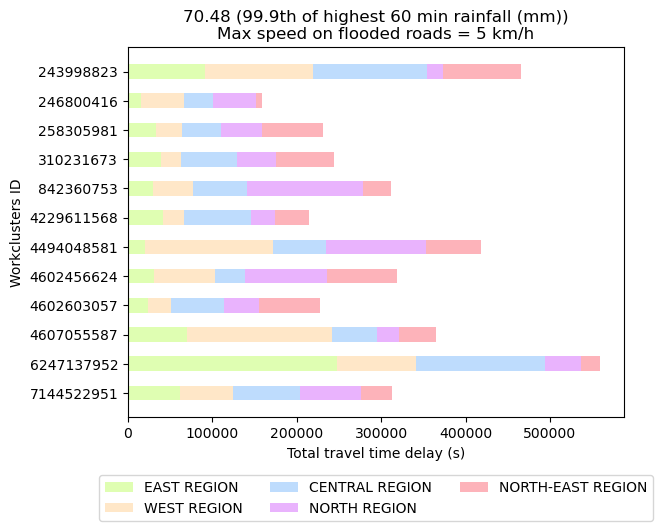

In [274]:
TTD = floodedRouting.TravelTimeDelay(flooded_df,dry_df,planningArea_shp)
TTD.get_planningArea_itinerary(itinerary_df=itinerary_df_list[list(itinerary_df_list)[0]],
                               colors=None,plot=True)
TTD.get_total_travel_time_delay()

# parameter inputs
flooded_maxspeed = int(5)
rf_type = 'highest 60 min rainfall (mm)'
rf_perc = 99.9
rf_map = {perc:rf_val for perc, rf_val in zip(percentiles,list(historical_ppt_percentiles[rf_type]))}
rf_value = rf_map[rf_perc]
# save fp
save_dir = os.path.join(os.getcwd(),"data","floodRouting")
save_fp = os.path.join(save_dir,f"barPlot_bus_routing_rfType{rf_type}_rfPerc{rf_perc}_maxspeed{flooded_maxspeed}.png")
# title from plot
title = f"{rf_value:.2f} ({rf_perc}th of {rf_type})\nMax speed on flooded roads = {flooded_maxspeed} km/h"
TTD.plot_total_travel_time_delay(title=title,save_fp=save_fp)

TODO:
- refactoring of code for private car transport by converting travel time to a dataframe for consistency in analysis for both private and public transit
- compute statistics for travel time delay per planning area